# Régression - NYC taxis

La deuxième cellule de ce notebook charge les données générées par le notebook `REG_01`.

In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error
import lightgbm as lgb

from utils import *

In [2]:
df_train = pd.read_parquet("data/nyc-taxis-tips/train_preprocessed.parquet")
X = df_train.drop("tip_amount", axis=1)
Y = df_train['tip_amount']
display(X.columns)
print(X.shape)

test = pd.read_parquet("data/nyc-taxis-tips/test_preprocessed.parquet")
test.drop(columns=["RatecodeID_6.0"], inplace=True)
print(test.shape)

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'is_rush_hour', 'duration', 'PU_loc', 'DO_loc',
       'VendorID_1', 'VendorID_2', 'RatecodeID_1.0', 'RatecodeID_2.0',
       'RatecodeID_3.0', 'RatecodeID_4.0', 'RatecodeID_5.0', 'RatecodeID_99.0',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'payment_type_1',
       'payment_type_2', 'payment_type_3', 'payment_type_4', 'PU_borough_7',
       'PU_borough_1', 'PU_borough_3', 'PU_borough_4', 'PU_borough_2',
       'PU_borough_6', 'PU_borough_5', 'DO_borough_7', 'DO_borough_1',
       'DO_borough_3', 'DO_borough_4', 'DO_borough_2', 'DO_borough_6',
       'DO_borough_5'],
      dtype='object')

(100000, 45)
(2627163, 45)


In [3]:
# divise les données 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print(X_train.columns)
print(X_train.shape, X_test.shape)

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'is_rush_hour', 'duration', 'PU_loc', 'DO_loc',
       'VendorID_1', 'VendorID_2', 'RatecodeID_1.0', 'RatecodeID_2.0',
       'RatecodeID_3.0', 'RatecodeID_4.0', 'RatecodeID_5.0', 'RatecodeID_99.0',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'payment_type_1',
       'payment_type_2', 'payment_type_3', 'payment_type_4', 'PU_borough_7',
       'PU_borough_1', 'PU_borough_3', 'PU_borough_4', 'PU_borough_2',
       'PU_borough_6', 'PU_borough_5', 'DO_borough_7', 'DO_borough_1',
       'DO_borough_3', 'DO_borough_4', 'DO_borough_2', 'DO_borough_6',
       'DO_borough_5'],
      dtype='object')
(75000, 45) (25000, 45)


In [4]:
# normaliser les données 

# Séparation des colonnes encodées (one-hot encoded) et des colonnes numériques à normaliser
columns_to_norm = [
    'passenger_count',
    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount',
    'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'duration'
]

cols_to_exclude = [
    'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
    'DO_location_lon', 'PU_loc', 'DO_loc'
]

# Copie des colonnes à exclure pour les conserver
X_train_excluded = X_train[cols_to_exclude]
X_test_excluded = X_test[cols_to_exclude]

X_train = X_train.drop(cols_to_exclude, axis=1)
X_test = X_test.drop(cols_to_exclude, axis=1)

# Normaliser les colonnes numériques de l'ensemble d'entraînement
scaler = StandardScaler()
X_train_normed = X_train.copy()
X_test_normed = X_test.copy()

# Normalisation sur l'ensemble d'entraînement
X_train_normed[columns_to_norm] = scaler.fit_transform(X_train[columns_to_norm])

# Appliquer la même transformation sur l'ensemble de test
X_test_normed[columns_to_norm] = scaler.transform(X_test[columns_to_norm])

# Réintégrer les colonnes exclues dans les ensembles normalisés
# X_train_normed = pd.concat([X_train_normed, X_train_excluded], axis=1)
# X_test_normed = pd.concat([X_test_normed, X_test_excluded], axis=1)

print(X_train_normed.shape)
print(X_train_normed.columns)

(75000, 39)
Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'is_rush_hour', 'duration', 'VendorID_1', 'VendorID_2',
       'RatecodeID_1.0', 'RatecodeID_2.0', 'RatecodeID_3.0', 'RatecodeID_4.0',
       'RatecodeID_5.0', 'RatecodeID_99.0', 'store_and_fwd_flag_N',
       'store_and_fwd_flag_Y', 'payment_type_1', 'payment_type_2',
       'payment_type_3', 'payment_type_4', 'PU_borough_7', 'PU_borough_1',
       'PU_borough_3', 'PU_borough_4', 'PU_borough_2', 'PU_borough_6',
       'PU_borough_5', 'DO_borough_7', 'DO_borough_1', 'DO_borough_3',
       'DO_borough_4', 'DO_borough_2', 'DO_borough_6', 'DO_borough_5'],
      dtype='object')


In [5]:
# test data for Kaggle submission
columns_to_norm = [
    'passenger_count',
    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount',
    'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'duration'
]
cols_to_exclude = [
    'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
    'DO_location_lon', 'PU_loc', 'DO_loc'
]

X_sub_excluded = test[cols_to_exclude]
X_sub = test.drop(cols_to_exclude, axis=1)

X_sub[columns_to_norm] = scaler.transform(X_sub[columns_to_norm])

# X_sub = pd.concat([X_sub, X_sub_excluded], axis=1)

# Ridge regression

In [83]:
# Modèle Ridge : 
model_ridge_CV = RidgeCV(alphas=np.linspace(1, 25, 100))
model_ridge_CV.fit(X_train_normed, y_train)
y_pred = model_ridge_CV.predict(X_test_normed)

mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Affichage des résultats
print("Mean Squared Error (MSE):", mse)
print("Coefficient de détermination (R2 Score):", r2)
print("meilleur alpha : ", model_ridge_CV.alpha_)

Mean Squared Error (MSE): 2.306209965831665
Coefficient de détermination (R2 Score): 0.609935828131456
meilleur alpha :  22.81818181818182


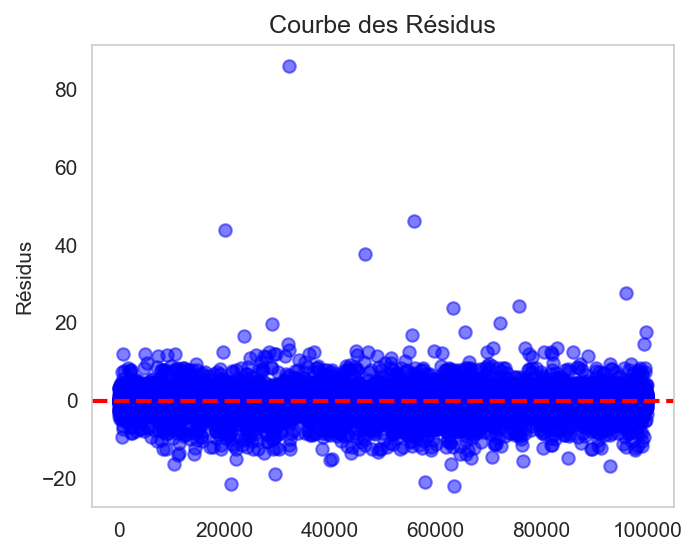

<Figure size 640x480 with 0 Axes>

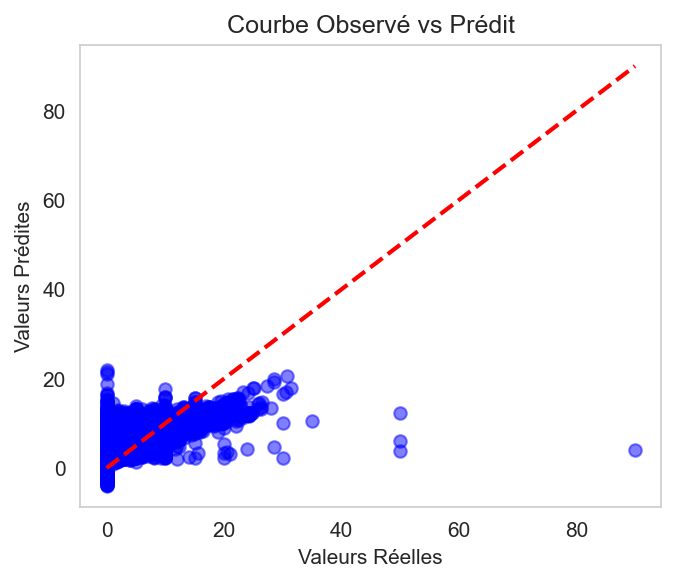

<Figure size 640x480 with 0 Axes>

In [84]:
residuals = y_test - y_pred

plt.figure(figsize=(5, 4), dpi=150)
plt.plot(residuals, "o", color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.ylabel("Résidus")
plt.title("Courbe des Résidus")
plt.grid()
plt.show()
plt.savefig("figures/residual_ridge.png")

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 4), dpi=150)
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel("Valeurs Réelles")
plt.ylabel("Valeurs Prédites")
plt.title("Courbe Observé vs Prédit")
plt.grid()
plt.show()
plt.savefig("figures/obs_predicted_ridge.pdf")

In [85]:
predictions = model_ridge_CV.predict(X_sub)

df_pred = pd.DataFrame(predictions, columns=["tip_amount"]).reset_index().rename(columns={"index": "row_ID"})
display(df_pred.head(15))
print(sum(df_pred["tip_amount"] < 0))
df_pred.loc[df_pred.tip_amount < 0, "tip_amount"] = 0
#df_pred.to_parquet("submission/nyc-taxis-tips/regression_sub_1bis.parquet", index=False)
df_pred.to_parquet("submission/nyc-taxis-tips/Ridge_sub_1_corrected.parquet", index=False)

,row_ID,tip_amount
0,0,2.067147
1,1,2.974402
2,2,-2.393869
3,3,2.351136
4,4,-1.664829
5,5,6.385503
6,6,4.027705
7,7,-1.934462
8,8,3.507854
9,9,7.366184


330480


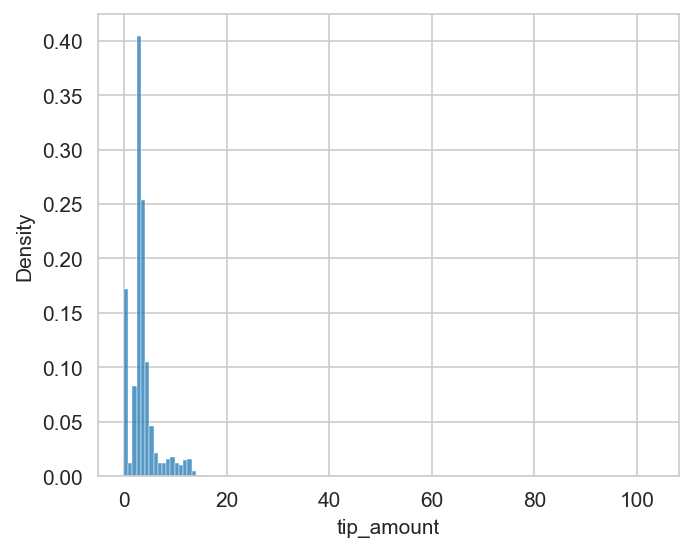

In [87]:
plt.figure(figsize=(5, 4), dpi=150)
sns.histplot(df_pred, x="tip_amount", bins=125, stat="density")
plt.gcf().savefig("figures/ridge_predictions.pdf", dpi=300)

# Random Forest Regressor

In [22]:
param_grid = {
    'n_estimators': [200], # [100, 200, 300],
    'max_depth': [10], # [5, 10, 15],
    'min_samples_split': [2], # [2, 3, 5],
    'min_samples_leaf': [40, 50, 60], # [50, 75, 100], # previously tested [30, 40, 50] which lead to 50 as best one
}

# Modèle RandomForest
rf_model = RandomForestRegressor(random_state=42)

# RandomizedSearchCV pour optimiser les hyperparamètres
rf_grid = GridSearchCV(estimator=rf_model,
                       param_grid=param_grid,
                       cv=5,
                       verbose=2,
                       n_jobs=-1)  # Utiliser tous les cœurs disponibles

# Entraîner le modèle avecGridSearchCV sur les données normalisées
rf_grid.fit(pd.concat([X_train_normed, X_test_normed], axis=0), pd.concat([y_train, y_test], axis=0))

# Meilleurs hyperparamètres trouvés
best_params = rf_grid.best_params_

# Affichage des résultats
print("Meilleurs hyperparamètres trouvés:", best_params)
print("Coefficient de détermination (R2 Score):", rf_grid.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Meilleurs hyperparamètres trouvés: {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 2, 'n_estimators': 200}
Coefficient de détermination (R2 Score): 0.7057588393058921


In [27]:
print(rf_grid.cv_results_)

{'mean_fit_time': array([41.61585126, 40.73262329, 37.20319591]), 'std_fit_time': array([3.10827865, 4.05464705, 0.77195188]), 'mean_score_time': array([0.22823358, 0.21604524, 0.20060973]), 'std_score_time': array([0.0228883 , 0.02183372, 0.01434354]), 'param_max_depth': masked_array(data=[10, 10, 10],
             mask=[False, False, False],
       fill_value=999999), 'param_min_samples_leaf': masked_array(data=[50, 50, 50],
             mask=[False, False, False],
       fill_value=999999), 'param_min_samples_split': masked_array(data=[2, 3, 5],
             mask=[False, False, False],
       fill_value=999999), 'param_n_estimators': masked_array(data=[200, 200, 200],
             mask=[False, False, False],
       fill_value=999999), 'params': [{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 3, 'n_estimators': 200}, {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 5,

TypeError: RegressorMixin.score() missing 2 required positional arguments: 'X' and 'y'

In [50]:
best_rf = RandomForestRegressor(max_depth=10, min_samples_leaf=50, min_samples_split=2, n_estimators=200)
best_rf.fit(pd.concat([X_train_normed[["trip_distance","fare_amount", "RatecodeID_99.0", "payment_type_1", "tolls_amount"]], X_test_normed[["trip_distance","fare_amount", "RatecodeID_99.0", "payment_type_1", "tolls_amount"]]], axis=0), pd.concat([y_train, y_test], axis=0))
importances = best_rf.feature_importances_

In [51]:
forest_importances = pd.Series(importances, index=X_train_normed.columns)

ValueError: Length of values (5) does not match length of index (39)

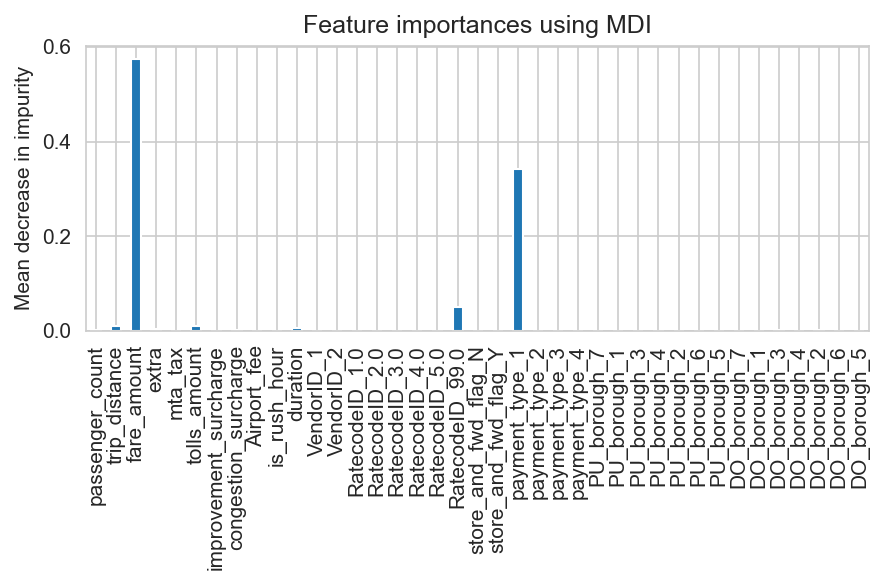

In [25]:
std_err = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0) / len(best_rf.estimators_)

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4), dpi=150)
ax = plt.gca()
forest_importances.plot.bar(yerr=std_err, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
# plt.xticks(rotation=90, ha='center', fontsize=8)
plt.tight_layout()
plt.gcf().savefig("figures/features_importance_rf.pdf", dpi=300)
plt.show()

In [52]:
predictions = best_rf.predict(X_sub[["trip_distance","fare_amount", "RatecodeID_99.0", "payment_type_1", "tolls_amount"]])
df_pred = pd.DataFrame(predictions, columns=["tip_amount"]).reset_index().rename(columns={"index": "row_ID"})
display(df_pred.head(15))
print(sum(df_pred["tip_amount"] < 0))
df_pred.loc[df_pred.tip_amount < 0, "tip_amount"] = 0
#df_pred.to_parquet("submission/nyc-taxis-tips/regression_sub_1bis.parquet", index=False)
df_pred.to_parquet("submission/nyc-taxis-tips/RF_sub_4_truncated.parquet", index=False)

,row_ID,tip_amount
0,0,1.778959
1,1,2.705986
2,2,0.000000
3,3,2.016893
4,4,0.000000
5,5,7.144546
6,6,4.529293
7,7,0.000000
8,8,3.112328
9,9,9.819922


0


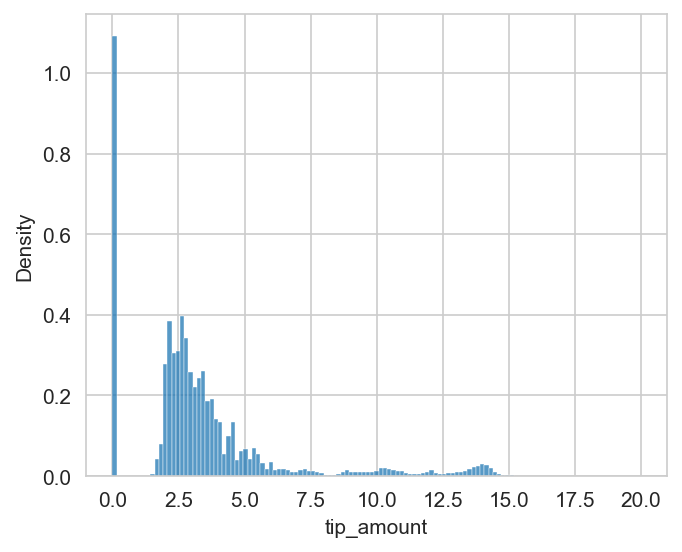

In [49]:
plt.figure(figsize=(5, 4), dpi=150)
sns.histplot(df_pred, x="tip_amount", bins=125, stat="density")
plt.gcf().savefig("figures/rf_predictions.pdf", dpi=300)

In [47]:
df_pred

,row_ID,tip_amount
0,0,1.959623
1,1,2.665226
2,2,0.003455
3,3,2.016031
4,4,0.039841
...,...,...
2627158,2627158,0.001841
2627159,2627159,3.669682
2627160,2627160,2.238839
2627161,2627161,3.034904


# Gradient boosting

In [70]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor()

param_grid = {"n_estimators": [75, 100, 125, 150], "num_leaves": [5, 10, 15], "learning_rate": [0.1, 0.05, 0.01]}

gbm = GridSearchCV(estimator, param_grid, cv=3, n_jobs=-1)
gbm.fit(X_train_normed, y_train)

print(f"Best parameters found by grid search are: {gbm.best_params_}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 32
[LightGBM] [Info] Start training from score 3.429543
Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 15}


In [39]:
gbm = lgb.LGBMRegressor(num_leaves=15, learning_rate=0.05, n_estimators=100)
gbm.fit(X_train_normed, y_train, eval_set=[(X_test_normed, y_test)], eval_metric="l2", callbacks=[lgb.early_stopping(5)])

# predict
y_pred = gbm.predict(X_test_normed, num_iteration=gbm.best_iteration_)

# eval
print(f"The R2 of prediction is: {r2_score(y_test, y_pred)}")
print(f"The MSE of prediction is: {mean_squared_error(y_test, y_pred)}")

# feature importances
print(f"Feature importances: {list(gbm.feature_importances_)}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 32
[LightGBM] [Info] Start training from score 3.429543
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 4.1045
The R2 of prediction is: 0.6989779569947381
The MSE of prediction is: 4.104496849101453
Feature importances: [5, 42, 328, 78, 0, 72, 0, 19, 2, 5, 93, 11, 0, 23, 0, 13, 0, 1, 95, 0, 0, 138, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 29, 4, 0, 12, 5, 0]


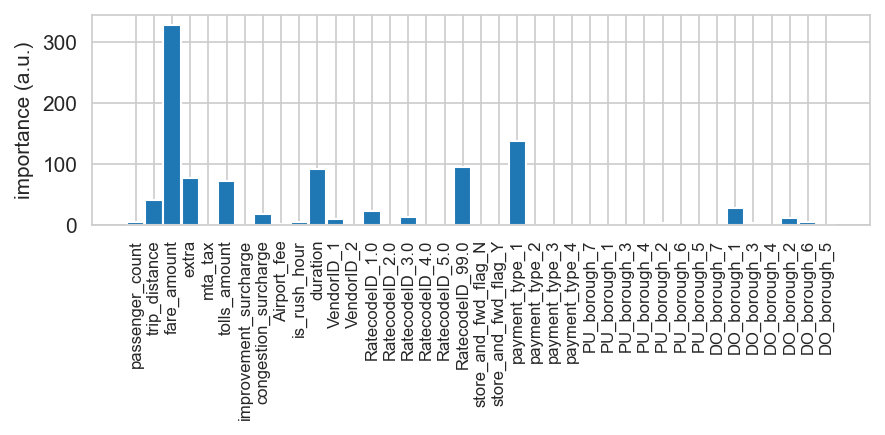

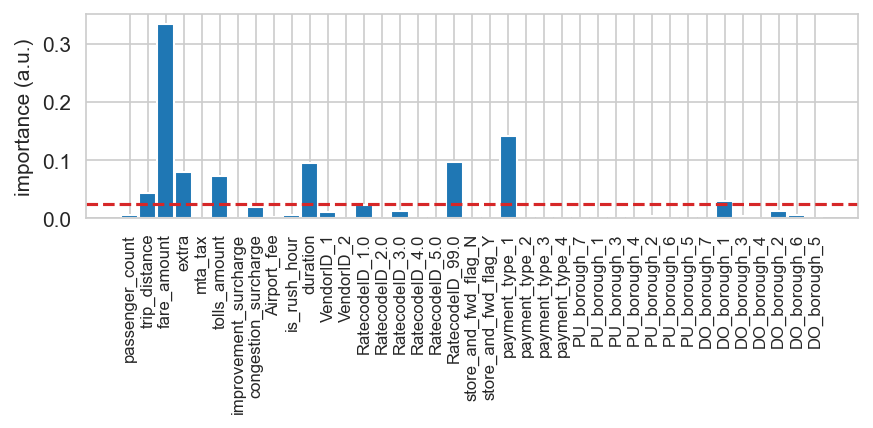

In [36]:
sns.set_style("whitegrid")
plt.figure(figsize=(6, 3), dpi=150)
plt.bar(x=X_test_normed.columns, height=gbm.feature_importances_, align="center", width=0.95)
plt.xticks(rotation=90, ha='center', fontsize=8)
plt.ylabel("importance (a.u.)")
plt.tight_layout()
plt.gcf().savefig("figures/features_importance_lightgbm.pdf", dpi=300)
plt.show()

sns.set_style("whitegrid")
plt.figure(figsize=(6, 3), dpi=150)
plt.bar(x=X_test_normed.columns, height=gbm.feature_importances_ / np.sum(gbm.feature_importances_), align="center", width=0.95)
plt.xticks(rotation=90, ha='center', fontsize=8)
plt.axhline(0.025, linestyle="--", color="C3")
plt.ylabel("importance (a.u.)")
plt.tight_layout()
plt.gcf().savefig("figures/relative_features_importance_lightgbm.pdf", dpi=300)
plt.show()

In [75]:
gbm.fit(pd.concat([X_train_normed, X_test_normed], axis=0), pd.concat([y_train, y_test], axis=0), eval_metric="l2")

# test data for Kaggle submission
predictions = gbm.predict(X_sub)

df_pred = pd.DataFrame(predictions, columns=["tip_amount"]).reset_index().rename(columns={"index": "row_ID"})
display(df_pred.head(15))
print(sum(df_pred["tip_amount"] < 0))
df_pred.loc[df_pred.tip_amount < 0, "tip_amount"] = 0
#df_pred.to_parquet("submission/nyc-taxis-tips/regression_sub_1bis.parquet", index=False)
df_pred.to_parquet("submission/nyc-taxis-tips/boosting_sub_1_corrected.parquet", index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 33
[LightGBM] [Info] Start training from score 3.430985


,row_ID,tip_amount
0,0,1.970240
1,1,2.669640
2,2,-0.002129
3,3,2.019273
4,4,0.039862
5,5,6.999687
6,6,4.326848
7,7,0.020413
8,8,3.270070
9,9,9.273275


16058


In [44]:
# subselecting variable

features_idx = np.where(gbm.feature_importances_ / np.sum(gbm.feature_importances_) > 0.001)[0]
print(len(features_idx))
gbm = lgb.LGBMRegressor(num_leaves=15, learning_rate=0.05, n_estimators=100)
gbm.fit(
    X_train_normed.iloc[:, features_idx], 
    y_train, 
    eval_set=[(X_test_normed.iloc[:, features_idx], y_test)], 
    eval_metric="l2", 
    callbacks=[lgb.early_stopping(5)]
)

# predict
y_pred = gbm.predict(X_test_normed.iloc[:, features_idx], num_iteration=gbm.best_iteration_)

# eval
print(f"The R2 of prediction is: {r2_score(y_test, y_pred)}")
print(f"The MSE of prediction is: {mean_squared_error(y_test, y_pred)}")

gbm.fit(
    pd.concat([X_train_normed.iloc[:, features_idx], X_test_normed.iloc[:, features_idx]], axis=0), 
    pd.concat([y_train, y_test], axis=0), 
    eval_metric="l2"
)

# test data for Kaggle submission
predictions = gbm.predict(X_sub.iloc[:, features_idx])

df_pred = pd.DataFrame(predictions, columns=["tip_amount"]).reset_index().rename(columns={"index": "row_ID"})
display(df_pred.head(15))
print(sum(df_pred["tip_amount"] < 0))
df_pred.loc[df_pred.tip_amount < 0, "tip_amount"] = 0
#df_pred.to_parquet("submission/nyc-taxis-tips/regression_sub_1bis.parquet", index=False)
df_pred.to_parquet("submission/nyc-taxis-tips/boosting_sub_2_features_selection.parquet", index=False)

20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 20
[LightGBM] [Info] Start training from score 3.429543
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	valid_0's l2: 4.10289
The R2 of prediction is: 0.6990961501429203
The MSE of prediction is: 4.1028852614600435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 20
[LightGBM] [Info] Start trai

,row_ID,tip_amount
0,0,1.959623
1,1,2.665226
2,2,0.003455
3,3,2.016031
4,4,0.039841
5,5,7.002663
6,6,4.328280
7,7,0.030761
8,8,3.264879
9,9,9.264999


13390


In [45]:
X_sub.shape

(2627163, 39)

In [58]:
raw_test = pd.read_parquet("./data/nyc-taxis-tips/test.parquet")

In [82]:
raw_test[["tpep_pickup_datetime"]].drop(index=366794).min()

tpep_pickup_datetime   2023-12-31 23:39:17
dtype: datetime64[us]